In this notebook, we provide examples of computing derivatives using the available operators in `torchfsm`. We use simple trigonometric functions as test cases, since their analytical derivatives are easy to compute and serve as reliable ground truth.

If you're implementing a new operator, it's a good practice to validate it using the simple experiments demonstrated here to ensure correctness. In addition to manually calculating the ground truth, you can also use the `sympy` library to compute derivatives symbolically

In [4]:
from sympy import *
x=symbols("x")
diff((sin(2*x)+sin(4*x))**2,x)

(sin(2*x) + sin(4*x))*(4*cos(2*x) + 8*cos(4*x))

Now, let's start our experiments. We could first give some helper functions for plot and calculations:

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchfsm.mesh import MeshGrid
from torchfsm.operator import run_operators
from typing import List, Union

def plot(
    gds: List[Union[torch.Tensor, np.ndarray]],
    pds: List[Union[torch.Tensor, np.ndarray]],
    x_label: List[str],
    labels: List[str],
):
    n_fig=len(gds)
    if n_fig!=len(pds) or n_fig!=len(x_label) or n_fig!=len(labels):
        raise ValueError("The length of gds, pds, x_label, and labels should be the same.")
    if n_fig==1:
        n_rows=1; n_cols=1
    else:
        if n_fig%2==0:
            n_rows=n_fig//2; n_cols=2 if n_fig>1 else 1
        else:
            n_rows=(n_fig)//3; n_cols=1 if n_fig==1 else 3
    _, axs = plt.subplots(nrows=n_rows,ncols=n_cols,
                            sharey=True,figsize=(4*n_cols,4*n_rows))
    axs=axs.flat if n_fig>1 else [axs]
    for i,ax in enumerate(axs):
        ax.plot(gds[i],label=labels[i])
        ax.plot(pds[i],label=f"{labels[i]} fsm", linestyle='dashed')
        ax.set_xlabel(x_label[i])
        ax.grid(True)
        ax.legend()
    for i_row in range(n_rows):
        axs[i_row*n_cols].set_ylabel("value")

In [2]:
mesh_grid=MeshGrid([(0, 2*torch.pi, 32),(0, 4*torch.pi, 64), (0, 8*torch.pi, 128)])
x,y,z=mesh_grid.bc_mesh_grid()
phi=torch.sin(x)+torch.cos(y)+torch.sin(z)+torch.cos(z)
u=torch.cat([torch.sin(x), 
             torch.cos(y), 
             torch.sin(z)+torch.cos(z)], 
            dim=1)
u_3d=torch.cat([torch.sin(y)+torch.cos(z), 
                torch.cos(x)-torch.sin(z),
                torch.cos(y)-torch.sin(x)], 
               dim=1)
x=mesh_grid.x.numpy();y=mesh_grid.y.numpy();z=mesh_grid.z.numpy()
x_mg,y_mg,z_mg=mesh_grid.bc_mesh_grid(numpy=True)

mesh_grid_2d=MeshGrid([(0, 2*torch.pi, 32),(0, 4*torch.pi, 64)])
x_2d,y_2d=mesh_grid_2d.bc_mesh_grid()
u_2d=torch.cat([torch.sin(y_2d), torch.cos(x_2d)], dim=1)
x_2d_mg,y_2d_mg=mesh_grid_2d.bc_mesh_grid(numpy=True)

## Notation

* $\mathbf{u}$: $n$ d vector field.
* $\phi$: scalar field (0d vector field.).
* $i$: index of the coordinate.
* $I$: maximum index of the coordinate.
* $u_i$: $i$ th component of the vector field.

## Spatial Derivative

`SpatialDeritivate` calculates the spatial derivative of a scalar field w.r.t to a spatial dimension:

$$
\frac{\partial ^n}{\partial i} \phi
$$

where $n=1, 2, 3, \cdots$

In [3]:
from torchfsm.operator import SpatialDerivative
phi_x, phi_y, phi_z, phi_yy = run_operators(
    phi,
    [SpatialDerivative(0,1), SpatialDerivative(1,1), SpatialDerivative(2,1), SpatialDerivative(1,2)],
    mesh_grid
)

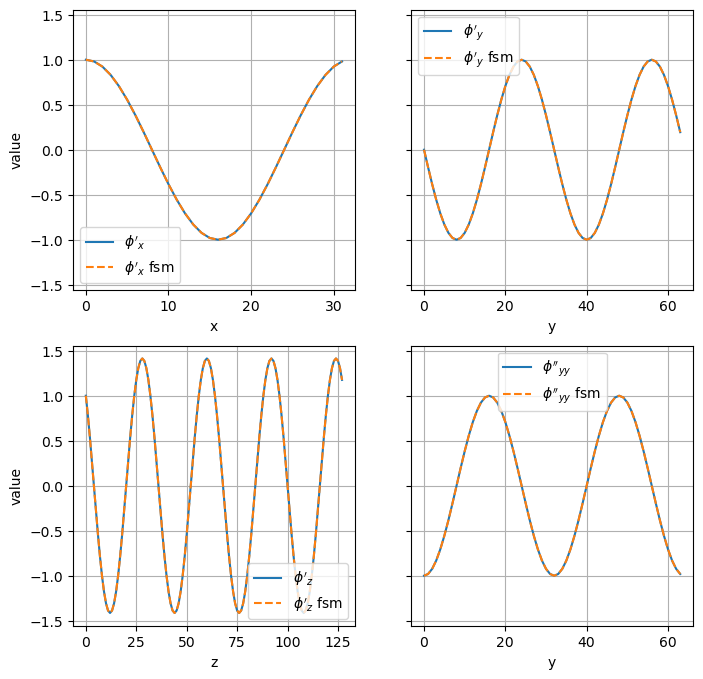

In [4]:
labels=["$\phi'_x$","$\phi'_y$","$\phi'_z$","$\phi''_{yy}$"]
x_label = ["x","y","z","y"]
gds = [
    np.cos(x),
    -1*np.sin(y),
    np.cos(z)-np.sin(z),
    -1*np.cos(y)
]
pds = [
    phi_x[0,0,:,15,15],
    phi_y[0,0,15,:,15],
    phi_z[0,0,15,15,:],
    phi_yy[0,0,15,:,15]
]
plot(gds, pds, x_label, labels)

## Gradient

`Grad` calculates the spatial gradient of a scalar field:

$$
\nabla \phi = \left[\begin{matrix}
\frac{\partial \phi}{\partial x} \\
\frac{\partial \phi}{\partial y} \\
\cdots \\
\frac{\partial \phi}{\partial I} \\
\end{matrix}
\right]
$$

In [5]:
from torchfsm.operator import Grad
grad=Grad()
grad_phi=grad(phi,mesh=mesh_grid)

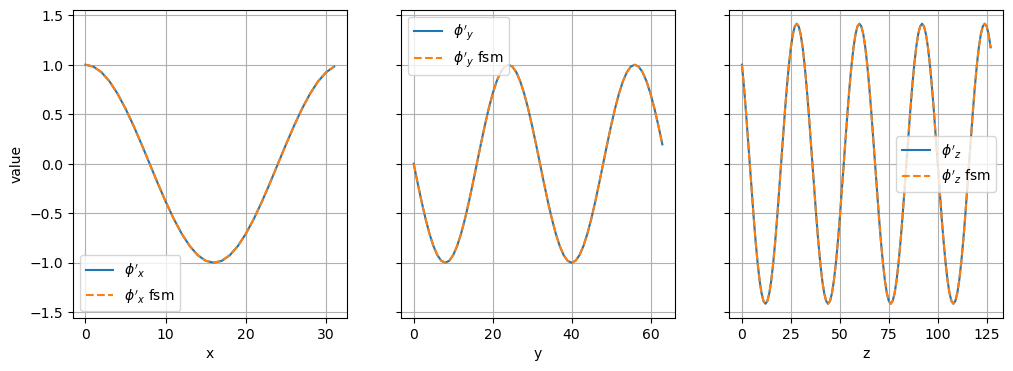

In [6]:
labels=["$\phi'_x$","$\phi'_y$","$\phi'_z$"]
x_label = ["x","y","z"]
gds = [
    np.cos(x),
    -1*np.sin(y),
    np.cos(z)-np.sin(z),
]
pds = [
    grad_phi[0,0,:,15,15],
    grad_phi[0,1,15,:,15],
    grad_phi[0,2,15,15,:],
]
plot(gds, pds, x_label, labels)

## Divergence

`Div` calculates the divergence of a vector field:

$$
\nabla \cdot \mathbf{u} = \sum_{i=0}^I \frac{\partial u_i}{\partial i}
$$


In [7]:
from torchfsm.operator import Div
div=Div()
div_u=div(u,mesh=mesh_grid)

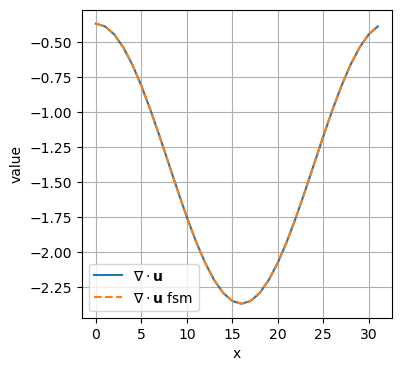

In [8]:
labels=[r"$\nabla \cdot \mathbf{u}$"]
gds = [
    (np.cos(x_mg)-1*np.sin(y_mg)+np.cos(z_mg)-np.sin(z_mg))[0,0,:,15,15]
]
pds = [
    div_u[0,0,:,15,15],
]
x_label = ["x"]
plot(gds, pds, x_label, labels)

## Laplacian

`Laplacian` calculates the Laplacian of a vector field:

$$
\nabla \cdot (\nabla\mathbf{u})
= 
\nabla^2\mathbf{u}
=
\left[\begin{matrix}
\sum_{i=0}^I \frac{\partial^2 u_x}{\partial i^2 } \\
\sum_{i=0}^I \frac{\partial^2 u_y}{\partial i^2 } \\
\cdots \\
\sum_{i=0}^I \frac{\partial^2 u_I}{\partial i^2 } \\
\end{matrix}
\right]
$$



In [9]:
from torchfsm.operator import Laplacian
laplacian=Laplacian()
lap_u=laplacian(u,mesh=mesh_grid)

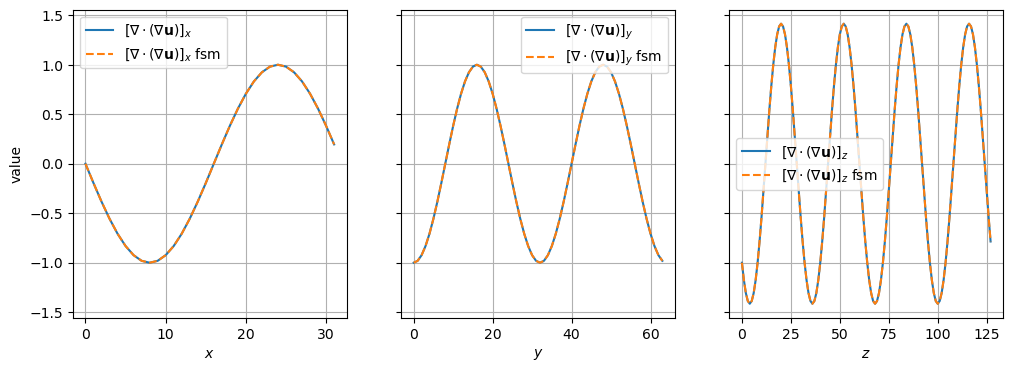

In [10]:
labels=[
    r"$[\nabla \cdot (\nabla\mathbf{u})]_x$",
    r"$[\nabla \cdot (\nabla\mathbf{u})]_y$",
    r"$[\nabla \cdot (\nabla\mathbf{u})]_z$",
]
x_label=["$x$","$y$","$z$"]
gds=[
    -np.sin(x),
    -np.cos(y),
    (-np.sin(z)-np.cos(z)),
]
pds=[
    lap_u[0,0,:,15,15],
    lap_u[0,1,15,:,15],
    lap_u[0,2,15,15,:],
]
plot(gds, pds, x_label, labels)

## Biharmonic

`Biharmonic` calculates the Biharmonic of a vector field:

$$ 
\nabla^4\mathbf{u}
=
\left[\begin{matrix}

(\sum_{i=0}^I\frac{\partial^2}{\partial i^2 })(\sum_{j=0}^I\frac{\partial^2}{\partial j^2 })u_x \\
(\sum_{i=0}^I\frac{\partial^2}{\partial i^2 })(\sum_{j=0}^I\frac{\partial^2}{\partial j^2 })u_y \\
\cdots \\
(\sum_{i=0}^I\frac{\partial^2}{\partial i^2 })(\sum_{j=0}^I\frac{\partial^2}{\partial j^2 })u_i \\
\end{matrix}
\right]
$$



In [11]:
from torchfsm.operator import Biharmonic
biharmonic=Biharmonic()
biharmonic_u=biharmonic(u,mesh=mesh_grid)

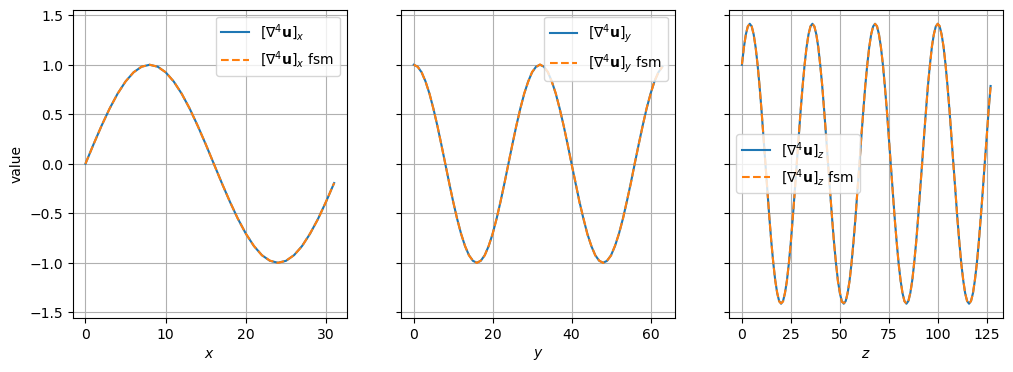

In [12]:
labels=[
    r"$[\nabla^4\mathbf{u}]_x$",
    r"$[\nabla^4\mathbf{u}]_y$",
    r"$[\nabla^4\mathbf{u}]_z$",
]
x_label=["$x$","$y$","$z$"]
gds=[
    np.sin(x),
    np.cos(y),
    np.sin(z)+np.cos(z),
]
pds=[
    biharmonic_u[0,0,:,15,15],
    biharmonic_u[0,1,15,:,15],
    biharmonic_u[0,2,15,15,:],
]
plot(gds, pds, x_label, labels)

## Curl

`Curl` calculates the curl of a 2d vector or 3d vector field:

* 2d vector field:
$$
\nabla \times \mathbf{u} = \frac{\partial u_y}{\partial x}-\frac{\partial u_x}{\partial y}
$$


In [13]:
from torchfsm.operator import Curl
curl=Curl()
curl_u_2d=curl(u_2d,mesh=mesh_grid_2d)

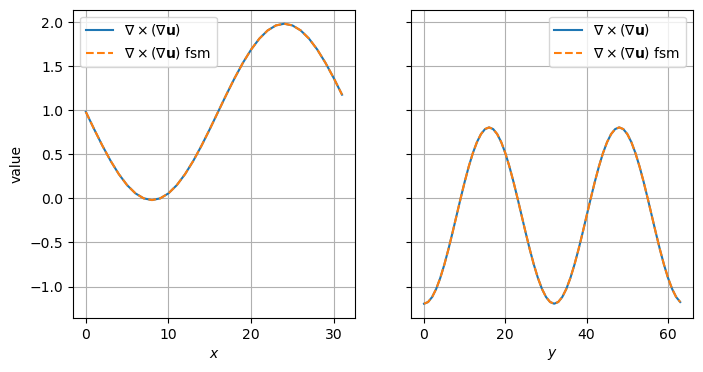

In [14]:
labels=[
    r"$\nabla \times (\nabla\mathbf{u})$",
    r"$\nabla \times (\nabla\mathbf{u})$",
]
x_label=["$x$","$y$"]
gd=-1*torch.sin(x_2d_mg)-torch.cos(y_2d_mg)
gds=[
    gd[0,0,:,15],
    gd[0,0,15,:],
]
pds=[
    curl_u_2d[0,0,:,15],
    curl_u_2d[0,0,15,:],
]
plot(gds, pds, x_label, labels)

* 3d vector field:
$$
\nabla \times \mathbf{u} 
=
\left[\begin{matrix}
\frac{\partial u_z}{\partial y}-\frac{\partial u_y}{\partial z} \\
\frac{\partial u_x}{\partial z}-\frac{\partial u_z}{\partial x} \\
\frac{\partial u_y}{\partial x}-\frac{\partial u_x}{\partial y}
\end{matrix}
\right]
$$

In [15]:
curl_u=curl(u_3d,mesh=mesh_grid)

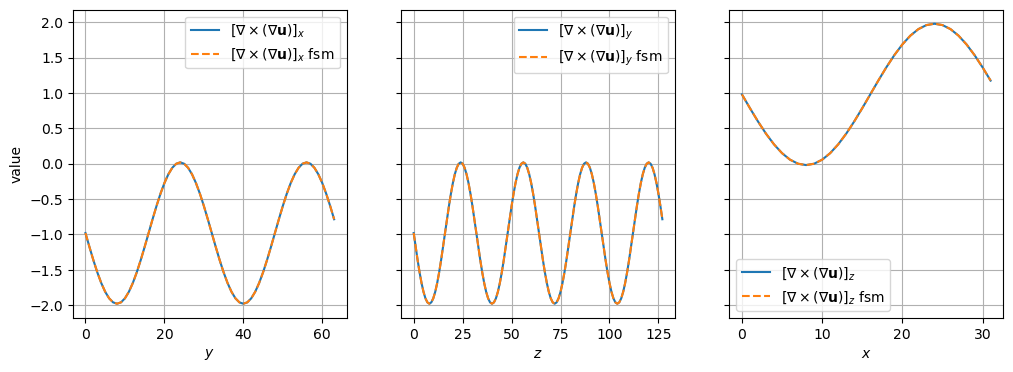

In [16]:
labels=[
    r"$[\nabla \times (\nabla\mathbf{u})]_x$",
    r"$[\nabla \times (\nabla\mathbf{u})]_y$",
    r"$[\nabla \times (\nabla\mathbf{u})]_z$",
]
x_label=["$y$","$z$","$x$"]
gd=np.concatenate( [-np.sin(y_mg)+np.cos(z_mg),
     -np.sin(z_mg)+np.cos(x_mg),
     -np.sin(x_mg)-np.cos(y_mg)],
     axis=1)
gds=[
    gd[0,0,15,:,15],
    gd[0,1,15,15,:],
    gd[0,2,:,15,15],
]
pds=[
    curl_u[0,0,15,:,15],
    curl_u[0,1,15,15,:],
    curl_u[0,2,:,15,15],
]
plot(gds, pds, x_label, labels)

## ConservativeConvection

`ConservativeConvection` calculates the convection of a vector field on itself.

$$
\nabla \cdot \mathbf{u}\mathbf{u}
=
\left[\begin{matrix}
\sum_{i=0}^I \frac{\partial u_i u_x }{\partial i} \\
\sum_{i=0}^I \frac{\partial u_i u_y }{\partial i} \\
\cdots\\
\sum_{i=0}^I \frac{\partial u_i u_I }{\partial i} \\
\end{matrix}
\right]
$$

In [17]:
from torchfsm.operator import ConservativeConvection
full_convection=ConservativeConvection()
full_conv_u=full_convection(u,mesh=mesh_grid)

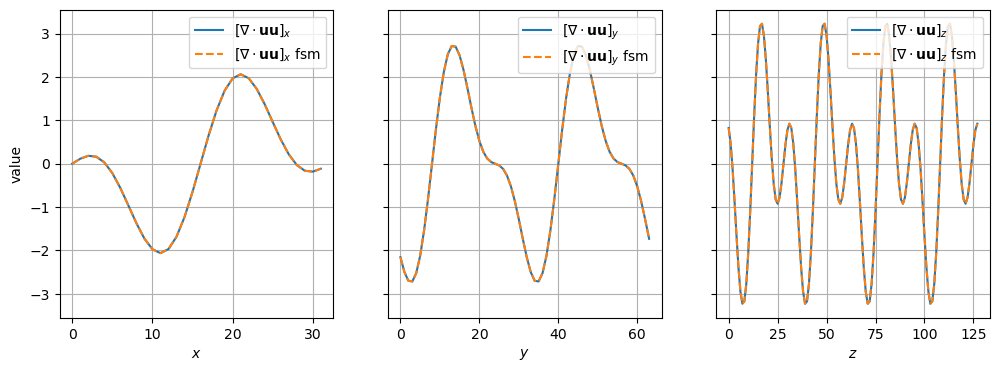

In [18]:
labels=[
    r"$[\nabla \cdot \mathbf{u}\mathbf{u}]_x$",
    r"$[\nabla \cdot \mathbf{u}\mathbf{u}]_y$",
    r"$[\nabla \cdot \mathbf{u}\mathbf{u}]_z$",
]
x_label=["$x$","$y$","$z$"]
gd=torch.cat(
    [(-torch.sin(z_mg) + torch.cos(z_mg))*torch.sin(x_mg) - torch.sin(x_mg)*torch.sin(y_mg) + 2*torch.sin(x_mg)*torch.cos(x_mg),
     (-torch.sin(z_mg) + torch.cos(z_mg))*torch.cos(y_mg) - 2*torch.sin(y_mg)*torch.cos(y_mg) + torch.cos(x_mg)*torch.cos(y_mg),
     (-2*torch.sin(z_mg) + 2*torch.cos(z_mg))*(torch.sin(z_mg) + torch.cos(z_mg)) - (torch.sin(z_mg) + torch.cos(z_mg))*torch.sin(y_mg) + (torch.sin(z_mg) + torch.cos(z_mg))*torch.cos(x_mg)],
    dim=1
)
gds=[
    gd[0,0,:,15,15],
    gd[0,1,15,:,15],
    gd[0,2,15,15,:],
]
pds=[
    full_conv_u[0,0,:,15,15],
    full_conv_u[0,1,15,:,15],
    full_conv_u[0,2,15,15,:],
]
plot(gds, pds, x_label, labels)

## Convection

`Convection` calculates the convection of a vector field on itself if the vector field is divergence free, i.e., $\nabla \cdot \mathbf{u} =0$.

$$
\mathbf{u} \cdot \nabla  \mathbf{u}
=
\left[\begin{matrix}
\sum_{i=0}^I u_i\frac{\partial u_x }{\partial i} \\
\sum_{i=0}^I u_i\frac{\partial u_y }{\partial i} \\
\cdots\\
\sum_{i=0}^I u_i\frac{\partial u_I }{\partial i} \\
\end{matrix}
\right]
$$

In [19]:
from torchfsm.operator import Convection
convection=Convection()
conv_u=convection(u,mesh=mesh_grid)

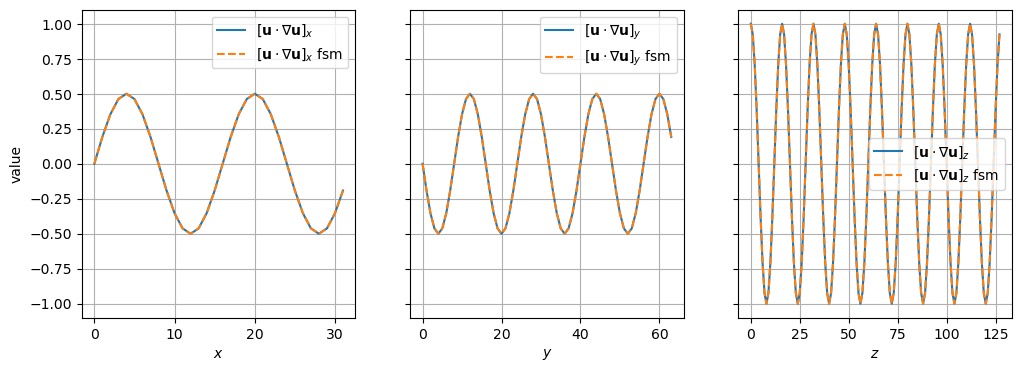

In [20]:
labels=[
    r"$[\mathbf{u} \cdot \nabla  \mathbf{u}]_x$",
    r"$[\mathbf{u} \cdot \nabla  \mathbf{u}]_y$",
    r"$[\mathbf{u} \cdot \nabla  \mathbf{u}]_z$",
]
x_label=["$x$","$y$","$z$"]
gds = [
    np.sin(x)*np.cos(x),
    -1*np.sin(y)*np.cos(y),
    np.cos(z)**2-np.sin(z)**2,
]
pds=[
    conv_u[0,0,:,15,15],
    conv_u[0,1,15,:,15],
    conv_u[0,2,15,15,:],
]
plot(gds, pds, x_label, labels)

### Conservative convection and convection

In the above, we have `ConservativeConvection`: $\nabla \cdot \mathbf{u}\mathbf{u}$ and `Convection`: $\mathbf{u} \cdot \nabla  \mathbf{u}$.

They have the following relationship:

$$
\nabla \cdot \mathbf{u}\mathbf{u}=\mathbf{u} \cdot \nabla  \mathbf{u}+ \mathbf{u} \nabla \cdot \mathbf{u}
$$

* $\nabla \cdot \mathbf{u}\mathbf{u}=\mathbf{u} \cdot \nabla  \mathbf{u}$ when $\mathbf{u}$ is divergence free, i.e., $\nabla \cdot \mathbf{u}=0$.
* $\nabla \cdot \mathbf{u}\mathbf{u}=2 \mathbf{u} \cdot \nabla  \mathbf{u}$ in 1d case.